# Linear regression

Math 5090

November 16, 2016

## Setup

The goal of regressions of all kinds is to describe the dependence of a variable (outcome) on a number of other variables (covariates or, in epidemiological terms, exposures). If $Y$ is an outcome of interest and $\mathbf{x} = (x_1, \dots, x_p)$ the vector of covariates, often the goal is to estimate $E[Y|\mathbf{x}]$.

**Remark**
  1. Recall that $E[Y|\mathbf{x}]$ is a function of $\mathbf{x}$ alone.
  2. In fact, $E[Y|\mathbf{x}]$ is the best predictor of $Y$ in the sense that it minimizes the MSE among functions of $\mathbf{x}$.
  3. Using something other than the MSE leads to other quantities of interest. For example, if we wanted predictors to minimize the MAD, the quantity would would care about would be $\hbox{median}(Y|\mathbf{x})$.


*Linear regression* makes the simplifying assumption that $E[Y|\mathbf{x}]$ is a linear function of $\mathbf{x}$. In terms of a particular sample, say $(Y_1, \mathbf{x}_1), \dots, (Y_1, \mathbf{x}_n)$, this is the same as supposing that
$$
    Y_i = \beta_0 + \beta_1x_{i,1} + \cdots + \beta_px_{i,p} + \varepsilon_i, \hbox{ } i = 1, \dots, n,
$$
where $\varepsilon_i$ is the difference between $Y_i$ and its expectation conditional on $\mathbf{x}_i$ (and so, $E[\varepsilon_i] = 0$ for all $i = 1, \dots, n$).

**Remark**
  1. $\beta_0, \dots, \beta_p$ do not depend on the particular observation $i$
  2. The relevant linearity in this equation is in the coefficients and not the covariates
    * $Y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 + \varepsilon_i$ describes a linear model
    * $Y_i = \beta_0 + \beta_1^2x_i + \varepsilon_i$ does not
  3. With this setup, options for estimating the coefficients are extremely limited. Neither the MLE nor the method of moments is available.

Since the conditional expectation of $Y$ given $\mathbf{x}$ minimizes the MSE, it makes sense to estimate the coefficients by minimizing the MSE within the sample. The *ordinary least squares* estimates are, therefore, the estimates for $\beta_0, \dots, \beta_p$ that minimize
$$
    f(\beta_0, \dots, \beta_p) := \sum_{i = 1}^n (Y_i - \beta_0 + \beta_1x_{i,1} + \cdots + \beta_px_{i,p})^2.
$$
Optimizing $f$ is a calculus problem.

**Assumptions**
  1. Homoskedasticity: $\hbox{var}(\varepsilon_i) = \sigma^2$ for all $i = 1, \dots, n$
  2. $\varepsilon_1, \dots, \varepsilon_n$ are independent
  3. Normal model: In addition to (1) and (2), $\varepsilon_i \sim N(\beta_0 + \beta_1x_{i,1} + \cdots + \beta_px_{i,p}, \sigma^2)$ for all $i = 1, \dots, n$

It is possible to estimate the normal model using MLE. The estimators are indentical to the least square estimators, but the distributional assumption allows to derive confidence intervals and hypothesis tests.

The normal model is assumed by the detailed reports generated by statistical software.

## Example

I will present an extended example of linear regression, going from data acquisition to preliminary results. The goal is to illustrate how regression can be applied to estimate racial/ethnic disparities (if any) to the total length of stay in a network of pediatric emergency departments.

### Data

For the example, we will use data gathered by the Pediatric Emergency Care Applied Research Network (<a href="http://www.pecarn.org">PECARN</a>) Core Data Project (PCDP).

PECARN is a large network of academic pediatric emergency department. PCDP is project that collects administrative data from the EDs within PECARN with the aim of
  1. Determining the basic epidemiology of visits to the ED
  2. Providing pilot data for study design development for PECARN

Data are extracted from the sites' EHRs and submitted to a data coordinating center once every year. All visits at the site are included in the submission. The project collects fundamental data elements related to each visit (such as the demographics of the patients) as well as diagnosis, procedure and injury codes.

Deidentified data sets from 2002-2014 are publically available (modulo a user agreement) here: http://www.pecarn.org/studyDatasets/StudyDetails?studyID=2.

For this analysis, I will use 2014 only. To get a sense of what's available, here is a link to the data dictionary: http://www.pecarn.org/studyDatasets/documents/PCDPOverviewofpublicusedatasets2013.pdf.

The data sets also include a document summarizing the variables: <a href="data/pcdp%20pud%202014.pdf">pcdp pud 2014.pdf</a>.

### Analysis plan

1. Data elements
   1. The main outcome will be the time from triage to discharge from the ED
   2. Covariates include: race, ethnicity, age, gender, triage category, triage day, triage hour, EMS

2. Analysis
    1. Profile the data
    2. Descriptive summaries of the outcome by race/ethnicity and other variables that seem interesting
    3. Box plots, scatter plots, CDFs of the outcome
    4. Show a few model fits

In [39]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10000
import scipy.stats as stats
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import sqlite3
import pcdp

In [2]:
visit = pcdp.load_data('pcdp')

In [3]:
visit.head()

,Year,Visit,Patient,Gender,Race,Ethnicity,RaceEthnicity,TriageCat,PayerType,Payer,EDDisposition,SentHome,ModeOfArrival,EMS,AgeInYears,TriageDayofWeek,TriageHour,LOS
0,2014,787284,2,Male,Other,Hispanic,Hispanic,Non-acute,Medicaid (including SCHIP),Government,Discharged,Sent home from ED,Non-EMS/Walk-in,Did not use EMS,5.826466,Monday,11.0,188.0
1,2014,235413,8,Female,White,Non-Hispanic,White NH,Emergent,Medicaid (including SCHIP),Government,Admitted,Not sent home from ED,Non-EMS/Walk-in,Did not use EMS,14.724968,Saturday,22.0,198.0
2,2014,453897,10,Female,Black or African American,Non-Hispanic,Black NH,Urgent,Medicaid (including SCHIP),Government,Admitted,Not sent home from ED,Non-EMS/Walk-in,Did not use EMS,6.050982,Monday,19.0,385.0
3,2014,781662,10,Female,Black or African American,Non-Hispanic,Black NH,Emergent,Medicaid (including SCHIP),Government,Admitted,Not sent home from ED,Non-EMS/Walk-in,Did not use EMS,6.393232,Sunday,17.0,332.0
4,2014,175773,37,Male,White,Hispanic,Hispanic,Not-urgent,Medicaid (including SCHIP),Government,Discharged,Sent home from ED,Non-EMS/Walk-in,Did not use EMS,6.327520,Tuesday,18.0,143.0


It's a good idea to summarize the outcome by the covariates to make sure that expected relations hold.

In [118]:
categoricals = ['RaceEthnicity', 'Gender', 'TriageCat', 'TriageDayofWeek', 'EMS', 'Payer']

table = [visit.groupby(c)[['LOS']].apply(lambda x: x.dropna().describe()).unstack() for c in categoricals]
table = [df.set_index(df.index.astype('str')) for df in table]
pd.concat(table, keys=categoricals)

LOS                               \
                                          count        mean         std  min   
RaceEthnicity   White NH               379697.0  223.290345  194.079117  0.0   
                Black NH               429413.0  184.121769  166.245747  0.0   
                Hispanic               255332.0  237.510367  247.734888  0.0   
                Other NH                91837.0  205.188181  182.102438  0.0   
Gender          Female                 556020.0  214.429905  200.457140  0.0   
                Male                   622369.0  207.439222  197.229026  0.0   
TriageCat       Critical                 8070.0  292.517224  329.155048  0.0   
                Emergent               175467.0  321.709581  276.943897  0.0   
                Urgent                 406402.0  257.379368  208.878595  0.0   
                Not-urgent             434484.0  155.589881  126.894623  0.0   
                Non-acute              123112.0  108.362800   87.600325  0.0   
TriageDayofWeek Sunday                 172465.0  197.930357  187.614964  0.0   
                Monday                 184573.0  217.429792  201.136399  0.0   
                Tuesday                170985.0  215.381993  200.603966  0.0   
                Wednesday              168685.0  214.395998  201.999483  0.0   
                Thursday               162882.0  215.010468  202.729049  0.0   
                Friday                 159108.0  214.990585  205.292069  0.0   
                Saturday               159738.0  199.379140  190.507692  0.0   
EMS             Did not use EMS       1011720.0  203.269328  188.611475  0.0   
                Used EMS               102183.0  293.104009  289.142960  0.0   
Payer           Commercial insurance   366666.0  231.464406  209.902044  0.0   
                Government             756311.0  202.172560  193.921241  0.0   
                Self-pay/Other          45868.0  177.718061  139.667788  0.0   

                                                                    
                                         25%    50%    75%     max  
RaceEthnicity   White NH              114.00  180.0  271.0  1440.0  
                Black NH               90.00  145.0  227.0  1440.0  
                Hispanic              106.00  172.0  272.0  1440.0  
                Other NH              101.00  163.0  254.0  1440.0  
Gender          Female                103.00  166.0  260.0  1440.0  
                Male                  100.00  161.0  250.0  1440.0  
TriageCat       Critical              125.00  198.0  301.0  1440.0  
                Emergent              176.00  248.0  350.0  1440.0  
                Urgent                143.00  210.0  302.0  1440.0  
                Not-urgent             85.00  127.0  188.0  1440.0  
                Non-acute              56.00   88.0  135.0  1440.0  
TriageDayofWeek Sunday                 97.00  154.0  239.0  1440.0  
                Monday                106.00  171.0  262.0  1440.0  
                Tuesday               104.00  168.0  261.0  1440.0  
                Wednesday             103.00  166.0  259.0  1440.0  
                Thursday              103.00  166.0  259.0  1440.0  
                Friday                101.75  166.0  260.0  1440.0  
                Saturday               96.00  154.0  241.0  1440.0  
EMS             Did not use EMS        98.00  158.0  248.0  1440.0  
                Used EMS              142.00  212.0  317.0  1440.0  
Payer           Commercial insurance  116.00  183.0  277.0  1440.0  
                Government             96.00  155.0  244.0  1440.0  
                Self-pay/Other         90.00  147.0  227.0  1440.0

Our main interest is in the association between race/ethnicity and the mean length of stay.

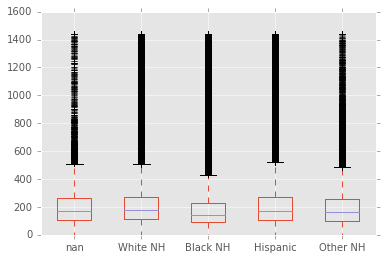

In [38]:
visit.pivot(index='Visit', columns='RaceEthnicity', values='LOS').plot.box()

Because of the evident heavy tails, in addition to LOS itself, it might be interesting to look at the natural logarithm of the LOS.

In [56]:
visit = visit.assign(log_LOS = np.where(visit.LOS > 0, np.log(visit.LOS), np.nan))

In [64]:
visit[['log_LOS']].dropna().describe().unstack().unstack()

,count,mean,std,min,25%,50%,75%,max
log_LOS,1178235.0,5.070478,0.748829,0.0,4.615121,5.09375,5.537334,7.272398


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D84DAC8>]], dtype=object)

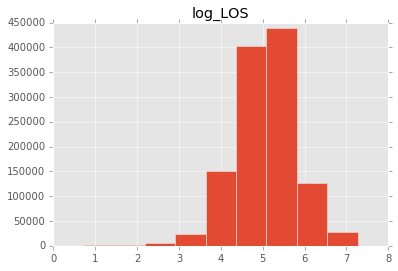

In [65]:
visit[['log_LOS']].dropna().hist()

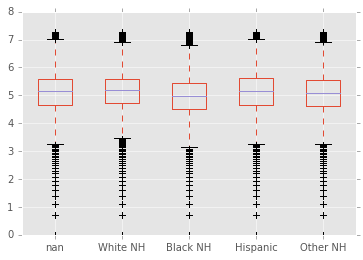

In [66]:
visit.pivot(index='Visit', columns='RaceEthnicity', values='log_LOS').plot.box()

In the first model, we just look at the association between race/ethnicity without taking anything else into account.

In [68]:
model1 = smf.ols('LOS ~ RaceEthnicity', data=visit).fit()

In [69]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LOS   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4721.
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        14:54:51   Log-Likelihood:            -7.7497e+06
No. Observations:             1156279   AIC:                         1.550e+07
Df Residuals:                 1156275   BIC:                         1.550e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                   223.2903      0.320    698.338      0.000       222.664   223.917
RaceEthnicity[T.Black NH]   -39.1686      0.439    -89.242      0.000       -40.029   -38.308
RaceEthnicity[T.Hispanic]    14.2200      0.504     28.200      0.000        13.232    15.208
RaceEthnicity[T.Other NH]   -18.1022      0.725    -24.985      0.000       -19.522   -16.682
==============================================================================
Omnibus:                   918265.136   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20266028.725
Skew:                           3.783   Prob(JB):                         0.00
Kurtosis:                      22.063   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Points arising**
  1. Table 1
    1. The left hand side of the first table shows basic information about the model and a crucial piece of information about how many observations were actually used.
    2. The "degrees of freedom" is similar to what one talks about in other contexts. Assuming the normal model, the degrees of freedom for the model agree with the GLRT.
    3. $R^2$: The correlation between the observed $Y_i$ and those predicted by the model.
    4. Adjusted $R^2$: This is a modified version of $R^2$, adjusted in such a way that, if the model is correct, then the expectation of $0$ (rather than slightly positive)
    5. $F$ statistic: Similar to the test for equality of variances for normally distributed variables. This test compares the variance of the residuals under your model to the silliest model possible.
    6. $p$-value ($F$ statistic): $p$-value for a test that $\beta_1 = \beta_2 = \cdots \beta_p = 0$ based on the $F$ statistic.
    7. AIC and BIC are model selection criteria. Intuitively, the approximate the out-of-sample error of your model (see *The Elements of Statistical Learning*).
    
  2. Table 2
    1. Pretty straightforward
    
  3. Table 3
    1. Durbin-Watson looks at the correlation in the resduals. Useless if the data have no intrinsic order, but extremely useful in econometrics
    2. Condition number. This gives a measure of the numerical difficulty of the model. Large condition numbers suggest that the results are inaccurate.

**Model fit**

The normal model assumes that the true residuals are normally distributed. One expedient for assessing the plausibility of this assumption is to assess the normality of the observed residuals under the proposed model. A quick check is given by the qq-plot.

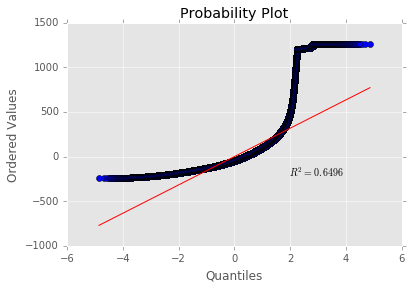

In [72]:
_ = stats.probplot(model1.resid, plot=plt)

That looks really bad, so let's try again with $\hbox{log}(\hbox{LOS})$.

In [73]:
model2 = smf.ols('log_LOS ~ RaceEthnicity', data=visit).fit()

In [74]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_LOS   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6337.
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        14:58:19   Log-Likelihood:            -1.2932e+06
No. Observations:             1156088   AIC:                         2.586e+06
Df Residuals:                 1156084   BIC:                         2.586e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                     5.1589      0.001   4292.013      0.000         5.156     5.161
RaceEthnicity[T.Black NH]    -0.2065      0.002   -125.138      0.000        -0.210    -0.203
RaceEthnicity[T.Hispanic]    -0.0138      0.002     -7.304      0.000        -0.018    -0.010
RaceEthnicity[T.Other NH]    -0.1131      0.003    -41.519      0.000        -0.118    -0.108
==============================================================================
Omnibus:                    72350.612   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           237356.526
Skew:                          -0.280   Prob(JB):                         0.00
Kurtosis:                       5.148   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretive issues**

We are using $\hbox{log_LOS}$ rather than $\hbox{LOS}$, so rather than have a model for $E[Y|\mathbf{x}]$, we have one for $E[\hbox{log}(Y)|\mathbf{x}]$. This complicates the interpretation of the model.

Before we could compare the mean of $Y$ given different factors. From model one, we could say that Hispanic patients spend on average 14.2200 minutes longer in the ED than white non-Hispanic patients, because the model says

$$
E[\hbox{LOS}|\hbox{RaceEthnicity} = x] = 223.2903 - 39.1686I(x = \hbox{Black NH}) + 14.22I(x = \hbox{Hispanic}) - 18.1022I(x = \hbox{Other NH}).
$$

One the other hand, the second model says
$$
E[\hbox{log}(\hbox{LOS})|\hbox{RaceEthnicity} = x] = 5.1589 - 0.2065I(x = \hbox{Black NH}) - 0.0138I(x = \hbox{Hispanic}) - 0.1131I(x = \hbox{Other NH}).
$$

So we can compare $\hbox{log}(\hbox{LOS})$, but we can't directly compare $\hbox{LOS}$. In practice, nobody cares about the distinction, so it's usual to interpret the exponentiated coefficients in terms of percentage increases.

In [86]:
np.exp(model2.params)

Intercept                    173.964438
RaceEthnicity[T.Black NH]      0.813458
RaceEthnicity[T.Hispanic]      0.986250
RaceEthnicity[T.Other NH]      0.893075
dtype: float64

Another qq-plot to assess normality.

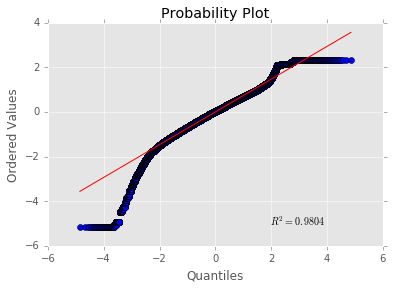

In [75]:
_ = stats.probplot(model2.resid, plot=plt)

Still pretty bad, but we're unlikely to do much better, so we'll take it.

This next step in assessing model fit would be to look into the assumption that the true residuals are homoskedastic. Based on the box plots below, that assumption at least seems pretty reasonable.

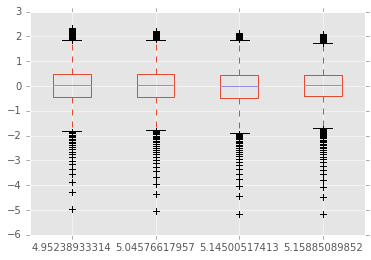

In [83]:
df = pd.DataFrame({'yhat': model2.fittedvalues, 'resid': model2.resid})
df.pivot(columns='yhat', values='resid').plot.box()

Now let's extend the model to take other things into account. It seems reasonable to suppose that the triage category should have an influence on the LOS and it could be related to race and ethnicity.

In [97]:
table = pd.crosstab(visit.TriageCat, visit.RaceEthnicity)
table

RaceEthnicity,White NH,Black NH,Hispanic,Other NH
TriageCat,,,,
Critical,3159,2511,1501,777
Emergent,77769,51403,29264,14766
Urgent,171465,120187,76384,31325
Not-urgent,99909,176554,120081,33036
Non-acute,19333,64811,28626,8999


In [100]:
table.apply(lambda x: x/x.sum()*100)

RaceEthnicity,White NH,Black NH,Hispanic,Other NH
TriageCat,,,,
Critical,0.850028,0.604382,0.586658,0.873986
Emergent,20.926178,12.372372,11.437684,16.609113
Urgent,46.138012,28.928240,29.854293,35.235031
Not-urgent,26.883636,42.495415,46.933040,37.159601
Non-acute,5.202147,15.599592,11.188325,10.122268


In [101]:
chi2, p, dof, _ = stats.chi2_contingency(table.values)
pd.DataFrame([[chi2, p, dof]], columns=['chi2', 'p', 'dof'])

,chi2,p,dof
0,71670.256637,0.0,12


In [102]:
model3 = smf.ols('log_LOS ~ RaceEthnicity + TriageCat', data=visit).fit()

In [103]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_LOS   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                 4.974e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:05:34   Log-Likelihood:            -1.0985e+06
No. Observations:             1126149   AIC:                         2.197e+06
Df Residuals:                 1126141   BIC:                         2.197e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                     5.2668      0.007    723.025      0.000         5.253     5.281
RaceEthnicity[T.Black NH]    -0.0120      0.001     -8.031      0.000        -0.015    -0.009
RaceEthnicity[T.Hispanic]     0.1553      0.002     92.083      0.000         0.152     0.159
RaceEthnicity[T.Other NH]     0.0078      0.002      3.252      0.001         0.003     0.013
TriageCat[T.Emergent]         0.2523      0.007     34.076      0.000         0.238     0.267
TriageCat[T.Urgent]           0.0502      0.007      6.860      0.000         0.036     0.064
TriageCat[T.Not-urgent]      -0.4688      0.007    -64.128      0.000        -0.483    -0.454
TriageCat[T.Non-acute]       -0.8490      0.007   -113.512      0.000        -0.864    -0.834
==============================================================================
Omnibus:                    59599.911   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           219886.529
Skew:                          -0.133   Prob(JB):                         0.00
Kurtosis:                       5.148   Cond. No.                         33.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
np.exp(model3.params)

Intercept                    193.796034
RaceEthnicity[T.Black NH]      0.988099
RaceEthnicity[T.Hispanic]      1.168059
RaceEthnicity[T.Other NH]      1.007873
TriageCat[T.Emergent]          1.286981
TriageCat[T.Urgent]            1.051433
TriageCat[T.Not-urgent]        0.625744
TriageCat[T.Non-acute]         0.427834
dtype: float64

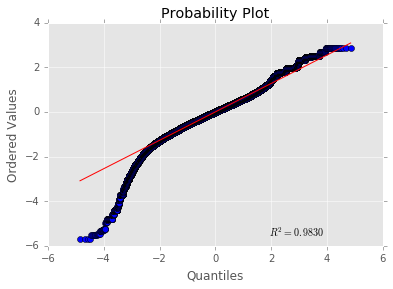

In [106]:
_ = stats.probplot(model3.resid, plot=plt)

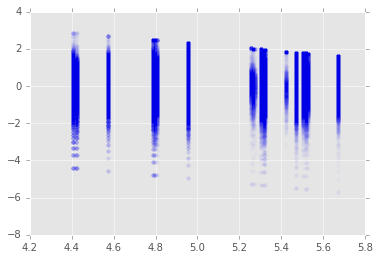

In [147]:
plt.scatter(model3.fittedvalues, model3.resid, alpha=0.01)

Let's see if we should add in the flag for whether or not ED arrival was through EMS.

In [107]:
table = pd.crosstab(visit.EMS, visit.RaceEthnicity)
table

RaceEthnicity,White NH,Black NH,Hispanic,Other NH
EMS,,,,
Did not use EMS,316946,365275,234818,79745
Used EMS,42332,34649,15810,7836


In [108]:
table.apply(lambda x: x/x.sum()*100)

RaceEthnicity,White NH,Black NH,Hispanic,Other NH
EMS,,,,
Did not use EMS,88.217481,91.336104,93.691846,91.052854
Used EMS,11.782519,8.663896,6.308154,8.947146


In [109]:
chi2, p, dof, _ = stats.chi2_contingency(table.values)
pd.DataFrame([[chi2, p, dof]], columns=['chi2', 'p', 'dof'])

,chi2,p,dof
0,5537.044261,0.0,3


In [110]:
model4 = smf.ols('log_LOS ~ RaceEthnicity + TriageCat + EMS', data=visit).fit()

In [111]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_LOS   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                 4.142e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:09:14   Log-Likelihood:            -1.0436e+06
No. Observations:             1064348   AIC:                         2.087e+06
Df Residuals:                 1064339   BIC:                         2.087e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                     5.2330      0.008    679.164      0.000         5.218     5.248
RaceEthnicity[T.Black NH]    -0.0142      0.002     -9.174      0.000        -0.017    -0.011
RaceEthnicity[T.Hispanic]     0.1630      0.002     94.062      0.000         0.160     0.166
RaceEthnicity[T.Other NH]     0.0089      0.002      3.594      0.000         0.004     0.014
TriageCat[T.Emergent]         0.2657      0.008     34.109      0.000         0.250     0.281
TriageCat[T.Urgent]           0.0698      0.008      9.062      0.000         0.055     0.085
TriageCat[T.Not-urgent]      -0.4428      0.008    -57.345      0.000        -0.458    -0.428
TriageCat[T.Non-acute]       -0.8241      0.008   -104.374      0.000        -0.840    -0.809
EMS[T.Used EMS]               0.1019      0.002     45.711      0.000         0.098     0.106
==============================================================================
Omnibus:                    52959.565   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189205.605
Skew:                          -0.116   Prob(JB):                         0.00
Kurtosis:                       5.052   Cond. No.                         33.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
np.exp(model4.params)

Intercept                    187.350052
RaceEthnicity[T.Black NH]      0.985899
RaceEthnicity[T.Hispanic]      1.176995
RaceEthnicity[T.Other NH]      1.008987
TriageCat[T.Emergent]          1.304279
TriageCat[T.Urgent]            1.072315
TriageCat[T.Not-urgent]        0.642246
TriageCat[T.Non-acute]         0.438634
EMS[T.Used EMS]                1.107305
dtype: float64

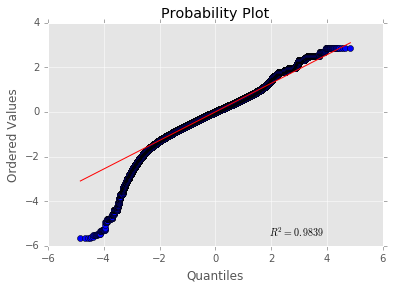

In [113]:
_ = stats.probplot(model4.resid, plot=plt)

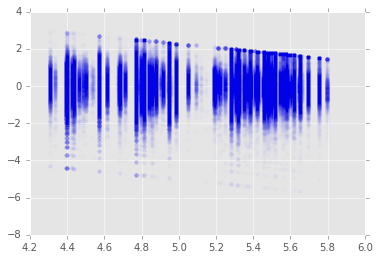

In [146]:
plt.scatter(model4.fittedvalues, model4.resid, alpha=0.01)

Similarly, payer type might be interesting.

In [119]:
table = pd.crosstab(visit.Payer, visit.RaceEthnicity)
table

RaceEthnicity,White NH,Black NH,Hispanic,Other NH
Payer,,,,
Commercial insurance,222957,67240,40069,30194
Government,145760,343143,203010,55598
Self-pay/Other,11078,17400,11474,4845


In [120]:
table.apply(lambda x: x/x.sum()*100)

RaceEthnicity,White NH,Black NH,Hispanic,Other NH
Payer,,,,
Commercial insurance,58.704564,15.718250,15.740926,33.313106
Government,38.378599,80.214268,79.751565,61.341395
Self-pay/Other,2.916837,4.067483,4.507509,5.345499


In [121]:
chi2, p, dof, _ = stats.chi2_contingency(table.values)
pd.DataFrame([[chi2, p, dof]], columns=['chi2', 'p', 'dof'])

,chi2,p,dof
0,211465.950746,0.0,6


In [123]:
model5 = smf.ols('log_LOS ~ RaceEthnicity + TriageCat + EMS + Payer', data=visit).fit()

In [124]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_LOS   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                 3.317e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:19:02   Log-Likelihood:            -1.0328e+06
No. Observations:             1057848   AIC:                         2.066e+06
Df Residuals:                 1057837   BIC:                         2.066e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                     5.2493      0.008    679.918      0.000         5.234     5.264
RaceEthnicity[T.Black NH]     0.0025      0.002      1.492      0.136        -0.001     0.006
RaceEthnicity[T.Hispanic]     0.1773      0.002     96.537      0.000         0.174     0.181
RaceEthnicity[T.Other NH]     0.0294      0.003     11.681      0.000         0.024     0.034
TriageCat[T.Emergent]         0.2658      0.008     34.161      0.000         0.251     0.281
TriageCat[T.Urgent]           0.0702      0.008      9.125      0.000         0.055     0.085
TriageCat[T.Not-urgent]      -0.4388      0.008    -56.885      0.000        -0.454    -0.424
TriageCat[T.Non-acute]       -0.8129      0.008   -103.018      0.000        -0.828    -0.797
EMS[T.Used EMS]               0.1025      0.002     45.953      0.000         0.098     0.107
Payer[T.Government]          -0.0404      0.002    -26.721      0.000        -0.043    -0.037
Payer[T.Self-pay/Other]      -0.1297      0.003    -37.573      0.000        -0.136    -0.123
==============================================================================
Omnibus:                    52043.264   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           185126.920
Skew:                          -0.111   Prob(JB):                         0.00
Kurtosis:                       5.037   Cond. No.                         39.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
np.exp(model5.params)

Intercept                    190.433517
RaceEthnicity[T.Black NH]      1.002476
RaceEthnicity[T.Hispanic]      1.194040
RaceEthnicity[T.Other NH]      1.029852
TriageCat[T.Emergent]          1.304451
TriageCat[T.Urgent]            1.072752
TriageCat[T.Not-urgent]        0.644800
TriageCat[T.Non-acute]         0.443588
EMS[T.Used EMS]                1.107942
Payer[T.Government]            0.960400
Payer[T.Self-pay/Other]        0.878397
dtype: float64

We haven't used any continuous variables in the model yet, so let's see if age is related to $\hbox{LOS}$.

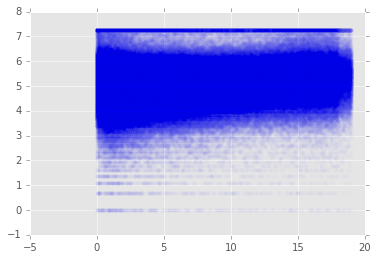

In [117]:
plt.scatter(visit.AgeInYears, visit.log_LOS, alpha=0.01)

That doesn't look very promising. We can compute the correlation to see if there's anything obvious going on.

In [128]:
visit[['LOS', 'AgeInYears']].dropna().corr()

,LOS,AgeInYears
LOS,1.000000,0.111015
AgeInYears,0.111015,1.000000


It's not much, but we can still see if it improves the model fit.

In [130]:
model6 = smf.ols('log_LOS ~ RaceEthnicity + TriageCat + EMS + Payer + AgeInYears', data=visit).fit()

In [131]:
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_LOS   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                 3.092e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:23:00   Log-Likelihood:            -1.0296e+06
No. Observations:             1057848   AIC:                         2.059e+06
Df Residuals:                 1057836   BIC:                         2.059e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                     5.1760      0.008    667.762      0.000         5.161     5.191
RaceEthnicity[T.Black NH]     0.0001      0.002      0.087      0.930        -0.003     0.003
RaceEthnicity[T.Hispanic]     0.1792      0.002     97.832      0.000         0.176     0.183
RaceEthnicity[T.Other NH]     0.0380      0.003     15.125      0.000         0.033     0.043
TriageCat[T.Emergent]         0.2615      0.008     33.717      0.000         0.246     0.277
TriageCat[T.Urgent]           0.0693      0.008      9.026      0.000         0.054     0.084
TriageCat[T.Not-urgent]      -0.4281      0.008    -55.659      0.000        -0.443    -0.413
TriageCat[T.Non-acute]       -0.7928      0.008   -100.729      0.000        -0.808    -0.777
EMS[T.Used EMS]               0.0962      0.002     43.220      0.000         0.092     0.101
Payer[T.Government]          -0.0287      0.002    -18.963      0.000        -0.032    -0.026
Payer[T.Self-pay/Other]      -0.1246      0.003    -36.200      0.000        -0.131    -0.118
AgeInYears                    0.0094      0.000     80.229      0.000         0.009     0.010
==============================================================================
Omnibus:                    52971.817   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           192043.487
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       5.076   Cond. No.                         234.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Meh.

Finally, let's throw in the rest of the triage variables and (to make things just a little more controversial) gender as well.

In [134]:
model7 = smf.ols('log_LOS ~ RaceEthnicity + TriageCat + EMS + Payer + TriageDayofWeek + Gender', data=visit).fit()

In [135]:
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_LOS   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                 1.976e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:26:50   Log-Likelihood:            -1.0312e+06
No. Observations:             1057831   AIC:                         2.062e+06
Df Residuals:                 1057813   BIC:                         2.063e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                        5.2380      0.008    664.495      0.000         5.223     5.253
RaceEthnicity[T.Black NH]        0.0011      0.002      0.686      0.493        -0.002     0.004
RaceEthnicity[T.Hispanic]        0.1777      0.002     96.881      0.000         0.174     0.181
RaceEthnicity[T.Other NH]        0.0311      0.003     12.368      0.000         0.026     0.036
TriageCat[T.Emergent]            0.2615      0.008     33.649      0.000         0.246     0.277
TriageCat[T.Urgent]              0.0654      0.008      8.509      0.000         0.050     0.080
TriageCat[T.Not-urgent]         -0.4419      0.008    -57.347      0.000        -0.457    -0.427
TriageCat[T.Non-acute]          -0.8157      0.008   -103.507      0.000        -0.831    -0.800
EMS[T.Used EMS]                  0.1044      0.002     46.846      0.000         0.100     0.109
Payer[T.Government]             -0.0419      0.002    -27.775      0.000        -0.045    -0.039
Payer[T.Self-pay/Other]         -0.1320      0.003    -38.320      0.000        -0.139    -0.125
TriageDayofWeek[T.Monday]        0.0743      0.002     32.633      0.000         0.070     0.079
TriageDayofWeek[T.Tuesday]       0.0575      0.002     24.932      0.000         0.053     0.062
TriageDayofWeek[T.Wednesday]     0.0500      0.002     21.585      0.000         0.045     0.055
TriageDayofWeek[T.Thursday]      0.0512      0.002     21.865      0.000         0.047     0.056
TriageDayofWeek[T.Friday]        0.0384      0.002     16.295      0.000         0.034     0.043
TriageDayofWeek[T.Saturday]     -0.0110      0.002     -4.661      0.000        -0.016    -0.006
Gender[T.Male]                  -0.0411      0.001    -32.882      0.000        -0.044    -0.039
==============================================================================
Omnibus:                    52692.507   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189091.429
Skew:                          -0.113   Prob(JB):                         0.00
Kurtosis:                       5.059   Cond. No.                         42.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
np.exp(model7.params)

Intercept                       188.287522
RaceEthnicity[T.Black NH]         1.001137
RaceEthnicity[T.Hispanic]         1.194477
RaceEthnicity[T.Other NH]         1.031591
TriageCat[T.Emergent]             1.298861
TriageCat[T.Urgent]               1.067601
TriageCat[T.Not-urgent]           0.642841
TriageCat[T.Non-acute]            0.442315
EMS[T.Used EMS]                   1.109996
Payer[T.Government]               0.958924
Payer[T.Self-pay/Other]           0.876300
TriageDayofWeek[T.Monday]         1.077162
TriageDayofWeek[T.Tuesday]        1.059222
TriageDayofWeek[T.Wednesday]      1.051298
TriageDayofWeek[T.Thursday]       1.052519
TriageDayofWeek[T.Friday]         1.039178
TriageDayofWeek[T.Saturday]       0.989059
Gender[T.Male]                    0.959741
dtype: float64

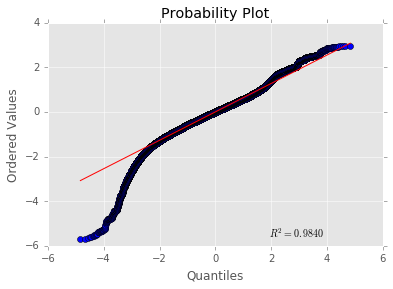

In [137]:
_ = stats.probplot(model7.resid, plot=plt)

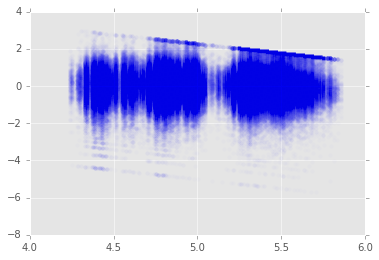

In [145]:
plt.scatter(model7.fittedvalues, model7.resid, alpha=0.01)

### Conclusions

ED LOS appears to be associated with race and ethnicity. In univariate comparisons, it is likely that the association was confounded by triage acuity (and possibly other variables).

As ED LOS is severely heavy tailed, the inferential statistics from our models may not be valid. Further exploration may be warranted.